In [1]:
import torch
import json

In [2]:
checkpoint_path = r'D:\fusion360segmentation\runs\encdec\nofilter64e3\version_0\checkpoints\epoch=47-val_loss=0.001085.ckpt'

In [3]:
ckpt = torch.load(checkpoint_path)

In [6]:
ckpt.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [20]:
ckpt['state_dict'].keys()

odict_keys(['encoder.v_in.f.0.weight', 'encoder.v_in.f.0.bias', 'encoder.e_in.f.0.weight', 'encoder.e_in.f.0.bias', 'encoder.l_in.f.0.weight', 'encoder.l_in.f.0.bias', 'encoder.f_in.f.0.weight', 'encoder.f_in.f.0.bias', 'encoder.v_to_e.mlp.f.0.weight', 'encoder.v_to_e.mlp.f.0.bias', 'encoder.e_to_l.mlp.f.0.weight', 'encoder.e_to_l.mlp.f.0.bias', 'encoder.l_to_f.mlp.f.0.weight', 'encoder.l_to_f.mlp.f.0.bias', 'decoder.layer_0.bias', 'decoder.layer_0.weight_g', 'decoder.layer_0.weight_v', 'decoder.layer_1.bias', 'decoder.layer_1.weight_g', 'decoder.layer_1.weight_v', 'decoder.layer_2.bias', 'decoder.layer_2.weight_g', 'decoder.layer_2.weight_v', 'decoder.layer_3.bias', 'decoder.layer_3.weight_g', 'decoder.layer_3.weight_v'])

In [1]:
from pspy import Part

In [5]:
Part('../pspy/brick.step').is_valid

True

In [7]:
codes = torch.load('D:/fusion360segmentation/codes64.pt')

In [21]:
codes_test = torch.load('D:/fusion360segmentation/codes64_test.pt')

In [19]:
len(codes)

23266

In [16]:
with open('D:/fusion360segmentation/simple_train_test.json','r') as f:
    train_test = json.load(f)

In [18]:
len(train_test['train'])

23266

In [20]:
len(train_test['test'])

4184

In [22]:
len(codes_test)

4184

In [35]:
from tqdm import tqdm
import os
from pspy import Part, PartOptions

In [39]:
opts = PartOptions()
opts.collect_inferences = False
opts.default_mcfs = False
opts.normalize = False
opts.num_random_samples = 0
opts.num_sdf_samples = 0
opts.num_uv_samples = 0
opts.tesselate = False


In [29]:
dataroot = r'D:\fusion360segmentation\s2.0.0\breps\step'

In [44]:
segroot = r'D:\fusion360segmentation\seg'

In [49]:
test_set = {}
for i,id in enumerate(tqdm(train_test['test'])):
    part = Part(os.path.join(dataroot, f'{id}.stp'), opts)
    nodes = codes_test[i]
    edges = part.brep.relations.face_to_face[:2]
    with open(os.path.join(segroot, f'{id}.seg'), 'r') as f:
        labels = [int(l.strip()) for l in f.readlines()]
    edges = torch.tensor(edges).long()
    labels = torch.tensor(labels).long()
    data = {'x':nodes,'edge_index':edges,'y':labels}
    test_set[id] = data


100%|██████████| 4184/4184 [02:17<00:00, 30.48it/s]


In [54]:
train_set = {}
for i,id in enumerate(tqdm(train_test['train'])):
    part = Part(os.path.join(dataroot, f'{id}.stp'), opts)
    nodes = codes[i]
    edges = part.brep.relations.face_to_face[:2]
    with open(os.path.join(segroot, f'{id}.seg'), 'r') as f:
        labels = [int(l.strip()) for l in f.readlines()]
    edges = torch.tensor(edges).long()
    labels = torch.tensor(labels).long()
    data = {'x':nodes,'edge_index':edges,'y':labels}
    train_set[id] = data

100%|██████████| 23266/23266 [12:28<00:00, 31.07it/s]


In [57]:
from reproducibility import create_subset

In [72]:
batch_data = [tg.data.Data(**test_set[id]) for id in train_test['test']]

In [73]:
batch = tg.data.Batch.from_data_list(batch_data, follow_batch='x')

In [74]:
torch.save(batch, 'D:/fusion360segmentation/test_allbatched_64.pt')

In [60]:
create_subset(train_test['train'],0,11) 

['120700_d818883a_15',
 '44742_71324dd1_2',
 '127965_c64a91da_0',
 '69337_2c778611_6',
 '123940_74d90c60_0',
 '121174_1345e289_0',
 '21642_b79d233e_12',
 '32766_acfa2aae_12',
 '22198_327974c6_11',
 '138700_ab763a46_128',
 '45539_26a6da23_5']

In [56]:
torch.save(train_set, 'D:/fusion360segmentation/train_set_64.pt')
torch.save(test_set, 'D:/fusion360segmentation/test_set_64.pt')

In [47]:
with open(os.path.join(segroot, '16550_e88d6986_0.seg'), 'r') as f:
    labels = [l.strip() for l in f.readlines()]
labels

['5', '0', '1', '3']

In [42]:
len(part.brep.nodes.faces)

7

In [4]:
import torch_geometric as tg

In [5]:
import pytorch_lightning as pl

In [2]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = tg.nn.GCNConv(in_channels, 2*out_channels, cached=True)
        self.conv2 = tg.nn.GCNConv(2*out_channels, out_channels, cached=True)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


In [ ]:
class GraphAutoencoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.gae = tg.nn.GAE(GCNEncoder(64, 16))
    
    def training_step(self, batch, batch_idx):
        z = self.gae.encode(batch.x, batch.edge_index)
        loss = self.gae.recon_loss(z, batch.edge_index)
        return loss

In [6]:
train = torch.load('D:/fusion360segmentation/train_allbatched_64.pt')
test = torch.load('D:/fusion360segmentation/test_allbatched_64.pt')

In [23]:
import torch_geometric as tg

In [24]:
model = tg.nn.GAE(GCNEncoder(64,16))

In [25]:
sd = torch.load('autoencoder_state_dict.pt', map_location = torch.device('cpu'))
model.load_state_dict(sd)


<All keys matched successfully>

In [26]:
list(model.parameters())[0]

Parameter containing:
tensor([ 0.0462,  0.2720, -0.1208, -0.1400,  0.9460,  0.1481, -0.1089, -1.6222,
         0.2028,  0.3227, -0.1967, -0.1267, -0.1174,  0.8117, -0.1558,  0.9616,
         0.4511, -0.1111,  0.3918, -0.1214,  0.2248,  0.1546, -0.1371,  0.1232,
        -0.3722, -1.1245, -0.1018,  0.1040,  0.4074,  0.3570, -0.1314,  0.7139],
       requires_grad=True)

In [30]:
test.x.shape

torch.Size([52926, 64])

In [34]:
test.edge_index.max()

tensor(52925)

In [29]:
with torch.no_grad():
    #z_train = model.encode(train.x, train.edge_index)
    z_test = model.encode(test.x, test.edge_index)

IndexError: index out of range in self

In [8]:
model = model.to('cuda')

In [10]:
x = train.x.to('cuda')
train_pos_edge_index = train.edge_index.to('cuda')

In [11]:
x_test = test.x.to('cuda')
test_pos_edge_index = test.edge_index.to('cuda')

In [81]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
z_train = model.encode(x, train_pos_edge_index)
z_test = model.encode(x_test, test_pos_edge_index)
train_autoenc_codes = z_train.detach().cpu()
test_autoenc_codes = z_test.detach().cpu()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [130]:
z_train

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [82]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)

In [85]:
for epoch in range(1, 10000):
    loss = train()
    print(f'Epoch {epoch}, Loss = {loss}')

Epoch 1, Loss = 0.847990870475769
Epoch 2, Loss = 0.8479244709014893
Epoch 3, Loss = 0.8476468324661255
Epoch 4, Loss = 0.847887396812439
Epoch 5, Loss = 0.8481466174125671
Epoch 6, Loss = 0.847467303276062
Epoch 7, Loss = 0.8479160070419312
Epoch 8, Loss = 0.8474486470222473
Epoch 9, Loss = 0.8473085761070251
Epoch 10, Loss = 0.8473975658416748
Epoch 11, Loss = 0.8475931882858276
Epoch 12, Loss = 0.8480320572853088
Epoch 13, Loss = 0.849049985408783
Epoch 14, Loss = 0.8477987051010132
Epoch 15, Loss = 0.8485477566719055
Epoch 16, Loss = 0.8480291366577148
Epoch 17, Loss = 0.848460853099823
Epoch 18, Loss = 0.8489224910736084
Epoch 19, Loss = 0.849065363407135
Epoch 20, Loss = 0.8488865494728088
Epoch 21, Loss = 0.848967432975769
Epoch 22, Loss = 0.8481463193893433
Epoch 23, Loss = 0.8467377424240112
Epoch 24, Loss = 0.8479066491127014
Epoch 25, Loss = 0.8482997417449951
Epoch 26, Loss = 0.8472940325737
Epoch 27, Loss = 0.8475198745727539
Epoch 28, Loss = 0.8477376699447632
Epoch 29, L

In [86]:
torch.save(model,'autoencoder_model.pt')

In [88]:
torch.save(model.state_dict(), 'autoencoder_state_dict.pt')

In [96]:
train_ids = create_subset(train_test['train'], 0, 10)
torch.cat([train_set[id]['x'] for id in train_ids],dim=0).shape
torch.cat([train_set[id]['y'] for id in train_ids],dim=0).shape

torch.Size([118])

In [112]:
from reproducibility import create_subset
from tqdm.notebook import tqdm
import torch
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import average_precision_score, f1_score

#train_set = torch.load('D:/fusion360segmentation/train_set_64.pt')
#test_set = torch.load('D:/fusion360segmentation/test_set_64.pt')

test_codes = torch.cat([test_set[id]['x'] for id in train_test['test']],dim=0)
test_labels = torch.cat([test_set[id]['y'] for id in train_test['test']],dim=0)

ap_scores = {}
for exp_size in tqdm([10, 100, 1000, 10000, 20000, len(train_test['train'])]):
    ap_scores[exp_size] = []
    for exp_num in tqdm(range(10)):
        train_ids = create_subset(train_test['train'], exp_num, exp_size)
        train_codes = torch.cat([train_set[id]['x'] for id in train_ids],dim=0)
        train_labels = torch.cat([train_set[id]['y'] for id in train_ids],dim=0)
        sgd_class = SGDClassifier()
        sgd_class.fit(train_codes, train_labels)
        test_scores = sgd_class.decision_function(test_codes)
        test_preds = test_scores.argmax(axis=1)
        ap = f1_score(test_labels, test_preds, average='macro')
        ap_scores[exp_size].append(ap)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

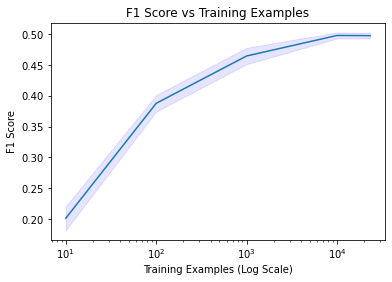

In [122]:
import numpy as np
from matplotlib import pyplot as plt
n = []
u = []
s = []
for k,v in ap_scores.items():
    mean = np.mean(v)
    std = np.std(v)
    n.append(k)
    u.append(mean)
    s.append(std)
n = np.array(n)
u = np.array(u)
s = np.array(s)

fig, ax = plt.subplots()
ax.plot(n, u)
ax.set_xscale('log')
ax.set_title('F1 Score vs Training Examples')
ax.set_ylabel('F1 Score')
ax.set_xlabel('Training Examples (Log Scale)')
ax.fill_between(n, (u-s/2), (u+s/2), color='b', alpha=.1)

In [120]:
np.std(ap_scores[10])

0.03867579521901832